<a href="https://colab.research.google.com/github/ImajiPietersz/FYP/blob/main/Isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:




df_mapped = pd.read_csv('/content/drive/MyDrive/FYP18-machine-vibration-source-separation/ LoRaWAN dataset/mapped_new.csv')
df_mapped

,Unnamed: 0.2,Unnamed: 0.1,Timestamp_x,SensorID,SequenceNumber,TotalLength,SourceAddress,TempHumiRange,TempHumiStatus,TempHumiEvent,...,machine12,machine13,machine14,machine15,machine16,machine17,machine18,machine19,machine20,machine21
0,26012,0,1668729853,sensor2,135,88,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
1,26013,1,1668729866,sensor4,255,88,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
2,26014,2,1668730437,sensor1,72,88,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
3,26015,3,1668730753,sensor2,136,88,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
4,26016,4,1668730766,sensor4,0,88,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161732,145588,8070,1682294148592,sensor4,73,88,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161733,145589,8071,1682294148592,sensor4,73,88,NaN,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161734,145590,8072,1682294379896,sensor1,76,88,NaN,0,0,0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161735,145592,8074,1682294379896,sensor1,76,88,NaN,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
indexes = df_mapped[df_mapped['machine2'] !=1].index
df_mapped.drop(indexes,inplace=True)


df1 = df_mapped.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Timestamp_x', 'SensorID','SequenceNumber', 'TotalLength', 'SourceAddress', 'TempHumiRange','TempHumiStatus', 'TempHumiEvent', 'TempHumiSenVal', 'XSenEvent', 'XPeakmg', 'XRMSmg', 'XKurtosis', 'XCrestFactor','XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement', 'YSenEvent', 'YPeakmg', 'YRMSmg', 'YKurtosis', 'YCrestFactor','YSkewness', 'YDeviation', 'YPeaktoPeakDisplacement', 'ZSenEvent', 'ZPeakmg', 'ZRMSmg', 'ZKurtosis', 'ZCrestFactor','ZSkewness', 'ZDeviation', 'ZPeaktoPeakDisplacement', 'LogIndex','DeviceEvents', 'DevicePowerSrc', 'DeviceBatteryVolt', 'DeviceTime', 'Timestamp_y', 'UID'],axis='columns')


In [ ]:
df1.loc[:,'XOAVelocity'] /= 100
df1.loc[:,'YOAVelocity'] /= 100
df1.loc[:,'ZOAVelocity'] /= 100


len(df1)

3043

In [ ]:
df1['x_faulty'] = ['Good' if row < 1.12 else 'Satisfactory' if row < 2.80 else 'Unsatisfactory' if row < 7.10 else 'Unacceptable' for row in df1['XOAVelocity']]
df1['y_faulty'] = ['Good' if row < 1.12 else 'Satisfactory' if row < 2.80 else 'Unsatisfactory' if row < 7.10 else 'Unacceptable' for row in df1['YOAVelocity']]
df1['z_faulty'] = ['Good' if row < 1.12 else 'Satisfactory' if row < 2.80 else 'Unsatisfactory' if row < 7.10 else 'Unacceptable' for row in df1['ZOAVelocity']]

df1['faulty'] = df1.apply(lambda row: 'Faulty' if (row['x_faulty'] == 'Unsatisfactory' or row['y_faulty'] == 'Unsatisfactory' or row['z_faulty'] == 'Unsatisfactory') else 'Good', axis=1)


# select the columns from machine1 to machine 21, excluding machine2
selected_cols = df1.iloc[:, 3:25].drop(columns=['machine2'])

# check if any of the values in the selected columns is equal to 1
any_ones = selected_cols.eq(1).any(axis=1)

# set the target column to 1 if machine 2 working alone or otherwise 0
df1['target'] = any_ones.apply(lambda x: 0 if x else 1)

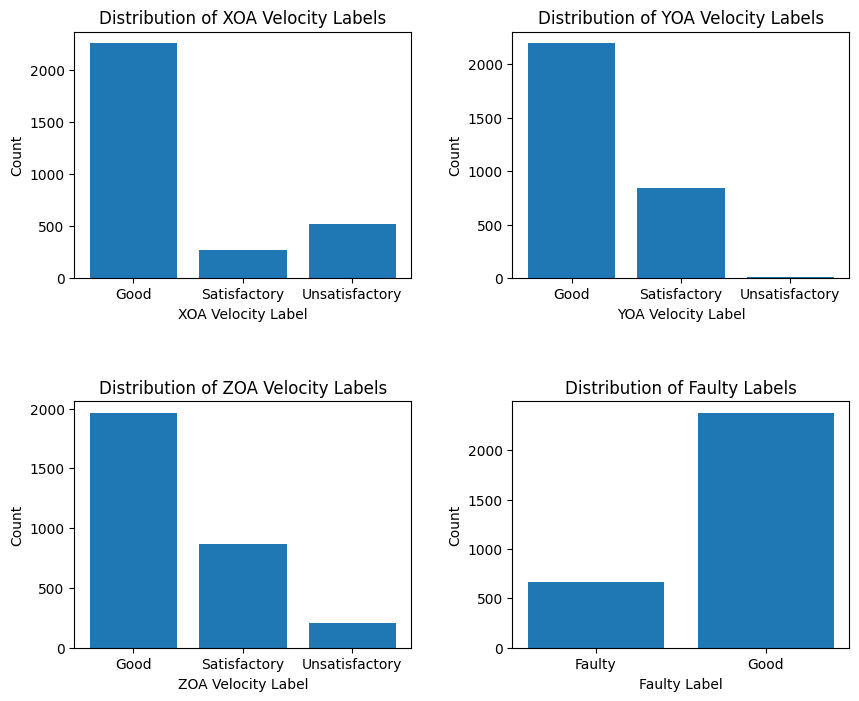

In [ ]:
# create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# plot for XOAVelocity vs x_faulty
data_x = df1.groupby('x_faulty')['XOAVelocity'].count()
axes[0, 0].bar(data_x.index, data_x.values)
axes[0, 0].set_xlabel('XOA Velocity Label')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of XOA Velocity Labels')

# plot for YOAVelocity vs y_faulty
data_y = df1.groupby('y_faulty')['YOAVelocity'].count()
axes[0, 1].bar(data_y.index, data_y.values)
axes[0, 1].set_xlabel('YOA Velocity Label')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of YOA Velocity Labels')

# plot for ZOAVelocity vs z_faulty
data_z = df1.groupby('z_faulty')['ZOAVelocity'].count()
axes[1, 0].bar(data_z.index, data_z.values)
axes[1, 0].set_xlabel('ZOA Velocity Label')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of ZOA Velocity Labels')

# plot for faulty column
data_f = df1.groupby('faulty')['faulty'].count()
axes[1, 1].bar(data_f.index, data_f.values)
axes[1, 1].set_xlabel('Faulty Label')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Faulty Labels')

# adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# display the plot
plt.show()

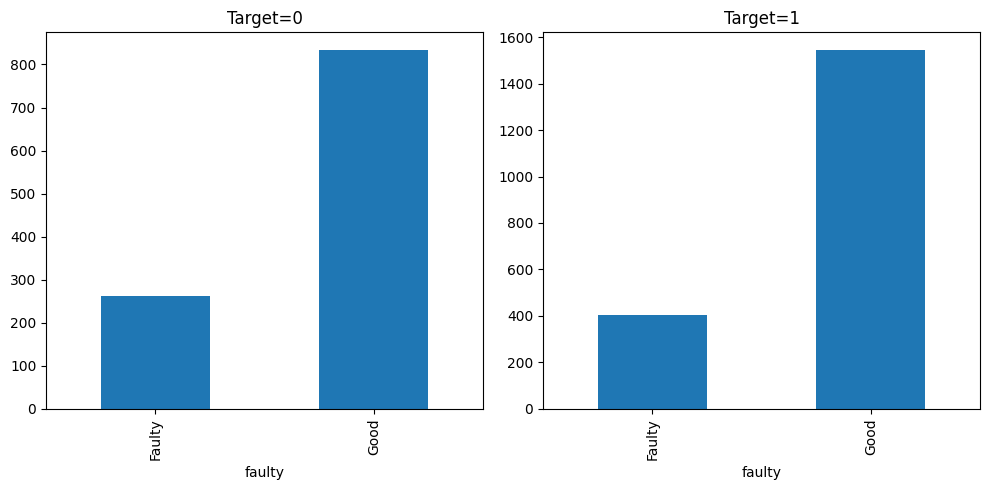

In [ ]:
# count the number of 'Faulty' and 'Good' labels for each value of 'target_column'
target_counts = df1.groupby(['target', 'faulty']).size().unstack()

# plot two bar charts, one for target_column = 0 and one for target_column = 1
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
target_counts.loc[0].plot(kind='bar', ax=axs[0], title='Target=0')
target_counts.loc[1].plot(kind='bar', ax=axs[1], title='Target=1')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score

def splitTrainTest(ratio, data, labels):

  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,labels_train, x_test,labels_test)

# Split the dataset into training and testing sets
X_train, y_train, X_test, y_test = splitTrainTest(0.7,df1[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity','converted']], df1['faulty'])
# Create an instance of the OneClassSVM class
ocs = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)

# Fit the model to the training data
ocs.fit(X_train[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity']])

# Predict the labels of the testing data
y_pred = ocs.predict(X_test[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity']])
y_test = pd.Series(np.array(y_test)).replace({"Good": 1, "Faulty": -1})

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9649507119386638


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
def splitTrainTest(ratio, data, labels):

  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,labels_train, x_test,labels_test)

# Split the dataset into training and testing sets
X_train, y_train, X_test, y_test = splitTrainTest(0.7,df1[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity','converted']], df1['faulty'])



# Train the Isolation Forest classifier
classifier = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed
classifier.fit(X_train[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity']])


y_pred = classifier.predict(X_test[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity']])
y_test = pd.Series(np.array(y_test)).replace({"Good": 1, "Faulty": -1})

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9748083242059146


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_test, y_pred, pos_label=-1) # how many of the predicted anomalies are actually faults
recall = recall_score(y_test, y_pred, pos_label=-1) # how many of the actual faults were correctly identified as anomalies
f1score = f1_score(y_test, y_pred, pos_label=-1)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.90      0.95       235
           1       0.97      1.00      0.98       678

    accuracy                           0.97       913
   macro avg       0.98      0.95      0.97       913
weighted avg       0.98      0.97      0.97       913



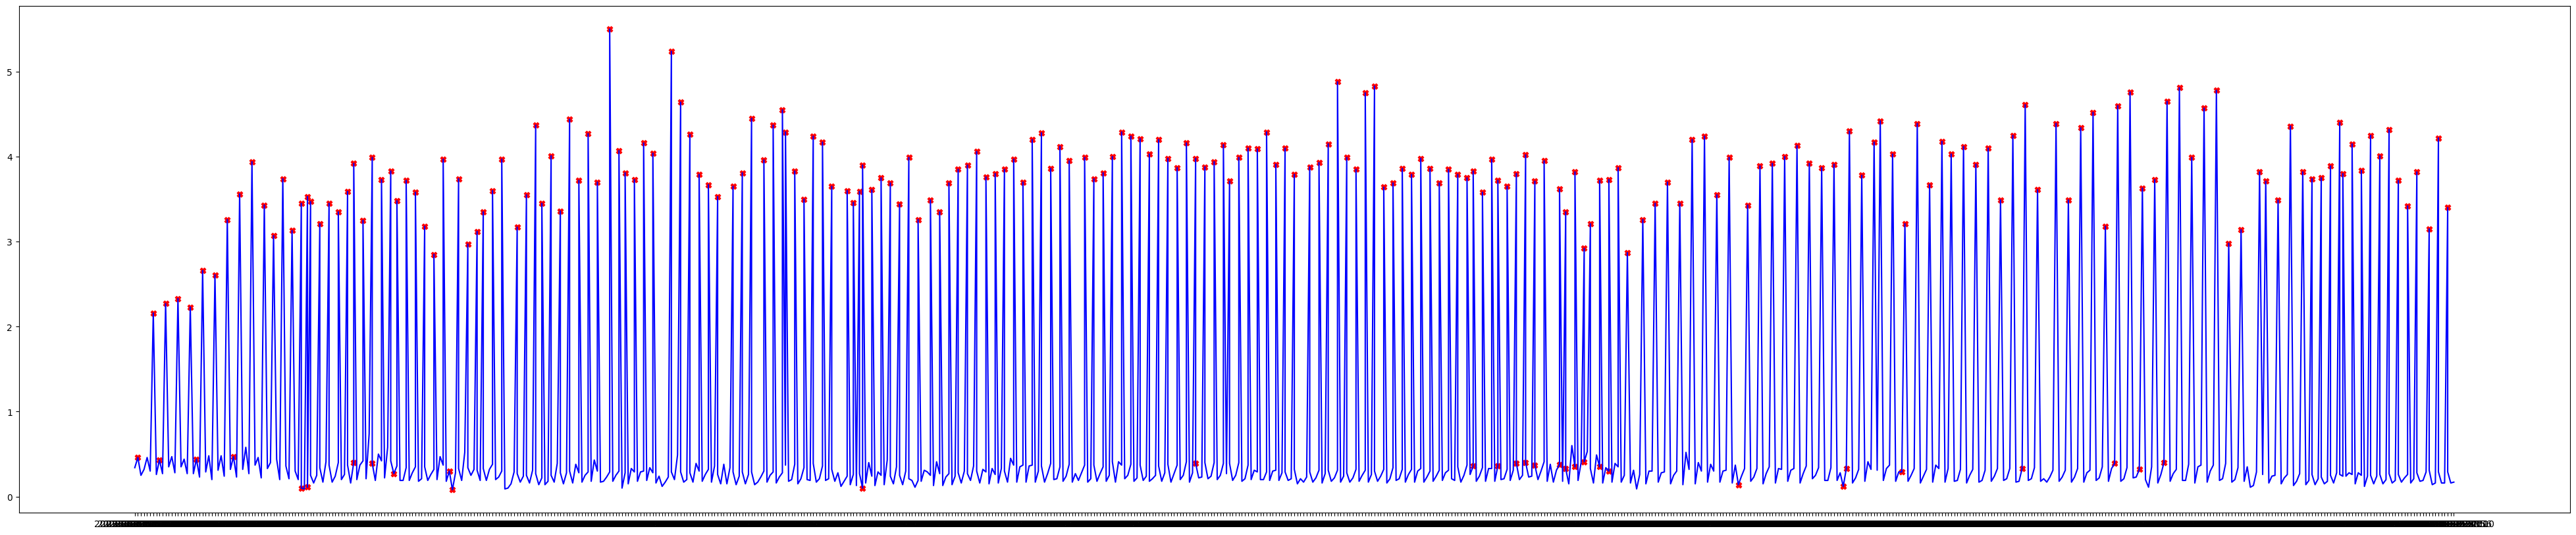

In [ ]:
fig, ax = plt.subplots(figsize=(50,10))
X_test['anomaly_svm'] = pd.Series(ocs.predict(X_test[['XOAVelocity', 'YOAVelocity', 'ZOAVelocity']])).values
anomaly = X_test.loc[X_test['anomaly_svm'] == -1, ['converted', 'XOAVelocity']]



ax.plot(X_test['converted'], X_test['XOAVelocity'], color='blue')
ax.scatter(anomaly['converted'],anomaly['XOAVelocity'],  marker='X',color='red')

plt.show();
